## Link score prediction with NN ##

In [1]:
import gzip

# Dataset loading
samples = []
with gzip.open("dataset/wiki-RfA.txt.gz", "rt", encoding="utf-8", errors="ignore") as f:
    block = {}
    for line in f:
        line = line.strip()
        if not line:
            if "SRC" in block and "TGT" in block and "VOT" in block:
                samples.append((block["SRC"], block["TGT"], int(block["VOT"])))
            block = {}
        else:
            key, value = line.split(":", 1)
            block[key] = value.strip()

print(f"Campioni totali: {len(samples)}")


Campioni totali: 198275


In [2]:
from sklearn.preprocessing import LabelEncoder
import torch

# User encoding
users = list(set([s[0] for s in samples] + [s[1] for s in samples]))
encoder = LabelEncoder()
user_ids = encoder.fit_transform(users)
user_map = dict(zip(users, user_ids))




In [3]:
# Data preparation
X = []
y = []
for src, tgt, vot in samples:
    if src in user_map and tgt in user_map:
        X.append([user_map[src], user_map[tgt]])
        y.append(vot)

X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.functional import cross_entropy

# Split train/val/test
X_train_split, X_temp, y_train_split, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

train_dataset = TensorDataset(X_train_split, y_train_split)
val_dataset   = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=256)

In [5]:
import torch.nn as nn

# Model for vote prediction
class VotePredictor(nn.Module):
    def __init__(self, num_users, emb_dim=64):
        super().__init__()
        self.emb = nn.Embedding(num_users, emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 3)  # 3 classes: -1, 0, +1 → shifted to 0,1,2
        )

    # Predizione
    def forward(self, x):
        src_emb = self.emb(x[:, 0])
        tgt_emb = self.emb(x[:, 1])
        combined = torch.cat([src_emb, tgt_emb], dim=1)
        return self.mlp(combined)


In [6]:
# Model and optimizer definition
model = VotePredictor(num_users=len(user_map)).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Early stopping setup
best_val_loss = float("inf")
patience, patience_counter = 10, 0

for epoch in range(1, 100): 
    # Training
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to("cuda"), yb.to("cuda")
        optimizer.zero_grad()
        out = model(xb)
        class_weights = torch.tensor([1.5, 1.0, 0.8]).to("cuda")
        loss = cross_entropy(out, yb + 1, weight=class_weights)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to("cuda"), yb.to("cuda")
            out = model(xb)
            val_loss = cross_entropy(out, yb + 1, weight=class_weights)
            total_val_loss += val_loss.item()

    # Print train/val loss in the same format
    print(f"[LSP] Epoch {epoch}, Train Loss: {total_train_loss:.4f}, Val Loss: {total_val_loss:.4f}")

    # Early stopping
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


[LSP] Epoch 1, Train Loss: 446.2954, Val Loss: 88.7276
[LSP] Epoch 2, Train Loss: 381.9612, Val Loss: 78.1211
[LSP] Epoch 3, Train Loss: 338.7730, Val Loss: 73.5273
[LSP] Epoch 4, Train Loss: 315.7178, Val Loss: 71.3392
[LSP] Epoch 5, Train Loss: 301.4341, Val Loss: 70.0723
[LSP] Epoch 6, Train Loss: 290.9647, Val Loss: 69.1681
[LSP] Epoch 7, Train Loss: 282.2548, Val Loss: 69.1661
[LSP] Epoch 8, Train Loss: 276.0938, Val Loss: 68.8715
[LSP] Epoch 9, Train Loss: 269.7039, Val Loss: 68.9244
[LSP] Epoch 10, Train Loss: 264.7700, Val Loss: 69.6026
[LSP] Epoch 11, Train Loss: 259.3297, Val Loss: 70.5534
[LSP] Epoch 12, Train Loss: 254.3695, Val Loss: 71.6351
[LSP] Epoch 13, Train Loss: 249.8567, Val Loss: 71.3821
[LSP] Epoch 14, Train Loss: 246.5941, Val Loss: 71.5748
[LSP] Epoch 15, Train Loss: 243.4668, Val Loss: 71.8614
[LSP] Epoch 16, Train Loss: 239.3198, Val Loss: 73.0881
[LSP] Epoch 17, Train Loss: 236.0061, Val Loss: 74.8400
[LSP] Epoch 18, Train Loss: 232.0589, Val Loss: 74.6926
E

              precision    recall  f1-score   support

      Oppose       0.55      0.72      0.63      6115
     Neutral       0.47      0.09      0.16      2017
     Support       0.88      0.87      0.88     21610

    accuracy                           0.79     29742
   macro avg       0.63      0.56      0.55     29742
weighted avg       0.79      0.79      0.78     29742



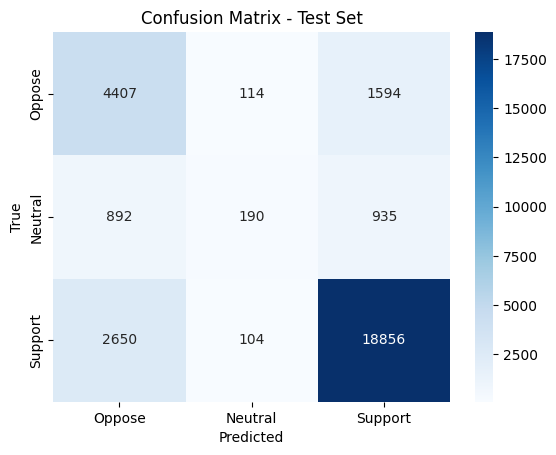

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions on the test set
model.eval()
with torch.no_grad():
    X_eval = X_test.to("cuda")              # use the updated split
    y_pred = model(X_eval).argmax(dim=1).cpu().numpy()
    y_true = (y_test + 1).numpy()           # shift from [-1,0,1] to [0,1,2]

# Classification report
print(classification_report(y_true, y_pred, target_names=["Oppose", "Neutral", "Support"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Oppose", "Neutral", "Support"],
            yticklabels=["Oppose", "Neutral", "Support"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.show()


## Link prediction with NN ##

In [8]:
import torch.nn as nn
import random
from sklearn.model_selection import train_test_split

# Build dataset for link prediction
positive_edges = set((s[0], s[1]) for s in samples)

users = list(user_map.keys())
negative_edges = set()
while len(negative_edges) < len(positive_edges):
    u1, u2 = random.sample(users, 2)
    if (u1, u2) not in positive_edges:
        negative_edges.add((u1, u2))

X_lp = []
y_lp = []

for src, tgt in positive_edges:
    X_lp.append([user_map[src], user_map[tgt]])
    y_lp.append(1)

for src, tgt in negative_edges:
    X_lp.append([user_map[src], user_map[tgt]])
    y_lp.append(0)

X_lp = torch.tensor(X_lp, dtype=torch.long)
y_lp = torch.tensor(y_lp, dtype=torch.float)

# Split train/val/test
X_lp_train, X_lp_temp, y_lp_train, y_lp_temp = train_test_split(
    X_lp, y_lp, test_size=0.3, random_state=42
)
X_lp_val, X_lp_test, y_lp_val, y_lp_test = train_test_split(
    X_lp_temp, y_lp_temp, test_size=0.5, random_state=42
)

print("Train size:", len(X_lp_train))
print("Val size:", len(X_lp_val))
print("Test size:", len(X_lp_test))


Train size: 264604
Val size: 56701
Test size: 56701


In [9]:
# Model
class LinkPredictor(nn.Module):
    def __init__(self, num_users, emb_dim=64):
        super().__init__()
        self.emb = nn.Embedding(num_users, emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        src_emb = self.emb(x[:, 0])
        tgt_emb = self.emb(x[:, 1])
        combined = torch.cat([src_emb, tgt_emb], dim=1)
        return self.mlp(combined).squeeze()

from torch.utils.data import DataLoader, TensorDataset
from torch.nn.functional import binary_cross_entropy

# Updated dataset and DataLoader
train_lp_dataset = TensorDataset(X_lp_train, y_lp_train)
val_lp_dataset   = TensorDataset(X_lp_val, y_lp_val)

train_lp_loader = DataLoader(train_lp_dataset, batch_size=256, shuffle=True)
val_lp_loader   = DataLoader(val_lp_dataset, batch_size=256)

lp_model = LinkPredictor(num_users=len(user_map)).to("cuda")
optimizer = torch.optim.Adam(lp_model.parameters(), lr=0.001)

# Early stopping setup
best_val_loss = float("inf")
patience, patience_counter = 5, 0

# Training loop with validation
for epoch in range(1, 21):
    # Training
    lp_model.train()
    total_train_loss = 0
    for xb, yb in train_lp_loader:
        xb, yb = xb.to("cuda"), yb.to("cuda")
        optimizer.zero_grad()
        out = lp_model(xb)
        loss = binary_cross_entropy(out, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation
    lp_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_lp_loader:
            xb, yb = xb.to("cuda"), yb.to("cuda")
            out = lp_model(xb)
            val_loss = binary_cross_entropy(out, yb)
            total_val_loss += val_loss.item()
    print(f"[LP] Epoch {epoch}, Train Loss: {total_train_loss:.4f}, Val Loss: {total_val_loss:.4f}")

    # Early stopping
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


[LP] Epoch 1, Train Loss: 527.2133, Val Loss: 75.9350
[LP] Epoch 2, Train Loss: 286.0867, Val Loss: 57.0713
[LP] Epoch 3, Train Loss: 226.2427, Val Loss: 52.1088
[LP] Epoch 4, Train Loss: 200.2838, Val Loss: 50.2748
[LP] Epoch 5, Train Loss: 183.8040, Val Loss: 50.1744
[LP] Epoch 6, Train Loss: 171.4304, Val Loss: 50.6228
[LP] Epoch 7, Train Loss: 160.7800, Val Loss: 51.8288
[LP] Epoch 8, Train Loss: 151.0816, Val Loss: 53.1057
[LP] Epoch 9, Train Loss: 141.4912, Val Loss: 55.3851
[LP] Epoch 10, Train Loss: 132.0644, Val Loss: 57.8778
Early stopping triggered


In [10]:
from sklearn.metrics import classification_report, roc_auc_score

# Link Prediction evaluation on the test set
lp_model.eval()
with torch.no_grad():
    X_eval = X_lp_test.to("cuda")              # use the updated split
    y_lp_pred = lp_model(X_eval).cpu().numpy()
    y_lp_true = y_lp_test.numpy()
    y_lp_bin = (y_lp_pred > 0.5).astype(int)

# Classification report
print(classification_report(y_lp_true, y_lp_bin, target_names=["NoLink", "Link"]))

# ROC-AUC
print("ROC-AUC:", roc_auc_score(y_lp_true, y_lp_pred))


              precision    recall  f1-score   support

      NoLink       0.92      0.90      0.91     28545
        Link       0.90      0.92      0.91     28156

    accuracy                           0.91     56701
   macro avg       0.91      0.91      0.91     56701
weighted avg       0.91      0.91      0.91     56701

ROC-AUC: 0.9653312167320619


## Node2vec link prediction ## 

In [11]:
import torch
import numpy as np
import networkx as nx
from torch_geometric.nn import Node2Vec

# Build directed graph ONLY with training edges
G_train = nx.DiGraph()
for src, tgt, vot in zip(X_train_split[:,0].numpy(), X_train_split[:,1].numpy(), y_train_split.numpy()):
    G_train.add_edge(src, tgt)  # use already mapped numeric IDs

# edge_index from training graph
edges_train = np.array(G_train.edges()).T   # shape (2, num_edges)
edge_index_train = torch.tensor(edges_train, dtype=torch.long)

# Initialize Node2Vec (on GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
node2vec = Node2Vec(
    edge_index_train,
    embedding_dim=64,
    walk_length=80,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    sparse=True
).to(device)

# Loader and optimizer
loader = node2vec.loader(batch_size=128, shuffle=True)
optimizer = torch.optim.SparseAdam(list(node2vec.parameters()), lr=0.01)

# Node2Vec training loop
for epoch in range(1, 15):
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = node2vec.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# Final embeddings (only from training edges)
emb_node2vec = node2vec.embedding.weight.data.cpu().numpy()


Epoch 1, Loss: 214.6953
Epoch 2, Loss: 98.1484
Epoch 3, Loss: 72.7264
Epoch 4, Loss: 67.7350
Epoch 5, Loss: 66.1915
Epoch 6, Loss: 65.5115
Epoch 7, Loss: 65.1696
Epoch 8, Loss: 64.9668
Epoch 9, Loss: 64.8428
Epoch 10, Loss: 64.7616
Epoch 11, Loss: 64.7145
Epoch 12, Loss: 64.6708
Epoch 13, Loss: 64.6443
Epoch 14, Loss: 64.6266


In [12]:
import torch.nn as nn
import torch

class Node2VecLinkPredictor(nn.Module):
    def __init__(self, num_users, emb_dim=64, emb_matrix=None):
        super().__init__()
        if emb_matrix is not None:
            # Initialize with pre‑computed Node2Vec embeddings
            self.emb = nn.Embedding.from_pretrained(
                torch.tensor(emb_matrix, dtype=torch.float),
                freeze=False   # False = embeddings can be updated during training
            )
        else:
            # Fallback: random embeddings
            self.emb = nn.Embedding(num_users, emb_dim)

        self.mlp = nn.Sequential(
            nn.Linear(emb_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        src_emb = self.emb(x[:, 0])
        tgt_emb = self.emb(x[:, 1])
        combined = torch.cat([src_emb, tgt_emb], dim=1)
        return self.mlp(combined).squeeze()


In [13]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.nn.functional import binary_cross_entropy
from sklearn.metrics import classification_report, roc_auc_score

# Split train/val/test for link prediction
X_lp_train, X_lp_temp, y_lp_train, y_lp_temp = train_test_split(
    X_lp, y_lp, test_size=0.3, random_state=42
)
X_lp_val, X_lp_test, y_lp_val, y_lp_test = train_test_split(
    X_lp_temp, y_lp_temp, test_size=0.5, random_state=42
)

# Dataset and DataLoader
train_lp_dataset = TensorDataset(X_lp_train, y_lp_train)
val_lp_dataset   = TensorDataset(X_lp_val, y_lp_val)

train_lp_loader = DataLoader(train_lp_dataset, batch_size=256, shuffle=True)
val_lp_loader   = DataLoader(val_lp_dataset, batch_size=256)

# Initialize model
lp_model = Node2VecLinkPredictor(
    num_users=len(user_map),
    emb_dim=64,
    emb_matrix=emb_node2vec   # Node2Vec embeddings trained only on train edges
).to("cuda")

optimizer = torch.optim.Adam(lp_model.parameters(), lr=0.001)

# Early stopping setup
best_val_loss = float("inf")
patience, patience_counter = 5, 0

# Training loop with validation
for epoch in range(1, 21):
    # Training
    lp_model.train()
    total_train_loss = 0
    for xb, yb in train_lp_loader:
        xb, yb = xb.to("cuda"), yb.to("cuda").float()
        optimizer.zero_grad()
        out = lp_model(xb)
        loss = binary_cross_entropy(out, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation
    lp_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_lp_loader:
            xb, yb = xb.to("cuda"), yb.to("cuda").float()
            out = lp_model(xb)
            val_loss = binary_cross_entropy(out, yb)
            total_val_loss += val_loss.item()
    print(f"[Node2Vec LP] Epoch {epoch}, Train Loss: {total_train_loss:.4f}, Val Loss: {total_val_loss:.4f}")

    # Early stopping
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


[Node2Vec LP] Epoch 1, Train Loss: 260.9269, Val Loss: 38.9596
[Node2Vec LP] Epoch 2, Train Loss: 146.2950, Val Loss: 34.1572
[Node2Vec LP] Epoch 3, Train Loss: 111.2573, Val Loss: 34.2355
[Node2Vec LP] Epoch 4, Train Loss: 90.1820, Val Loss: 36.2869
[Node2Vec LP] Epoch 5, Train Loss: 75.2905, Val Loss: 39.9484
[Node2Vec LP] Epoch 6, Train Loss: 63.7467, Val Loss: 44.2933
[Node2Vec LP] Epoch 7, Train Loss: 54.1950, Val Loss: 47.8575
Early stopping triggered


In [14]:
from sklearn.metrics import classification_report, roc_auc_score

# Link Prediction evaluation with Node2VecLinkPredictor
lp_model.eval()
with torch.no_grad():
    # Predictions on the test set
    y_lp_pred = lp_model(X_lp_test.to("cuda")).cpu().numpy()
    y_lp_true = y_lp_test.numpy()
    # Binarize predictions (threshold 0.5)
    y_lp_bin = (y_lp_pred > 0.5).astype(int)

# Classification report
print(classification_report(y_lp_true, y_lp_bin, target_names=["NoLink", "Link"]))

# ROC-AUC
print("ROC-AUC:", roc_auc_score(y_lp_true, y_lp_pred))


              precision    recall  f1-score   support

      NoLink       0.95      0.93      0.94     28545
        Link       0.93      0.95      0.94     28156

    accuracy                           0.94     56701
   macro avg       0.94      0.94      0.94     56701
weighted avg       0.94      0.94      0.94     56701

ROC-AUC: 0.9828754752535924


## Node2vec link score prediction ##

In [15]:
import torch.nn as nn
import torch

class Node2VecLinkScorePredictor(nn.Module):
    def __init__(self, num_users, emb_dim=64, emb_matrix=None):
        super().__init__()
        if emb_matrix is not None:
            # Initialize with pre‑computed Node2Vec embeddings
            self.emb = nn.Embedding.from_pretrained(
                torch.tensor(emb_matrix, dtype=torch.float),
                freeze=False   # False = embeddings can be updated during training
            )
        else:
            # Fallback: random embeddings
            self.emb = nn.Embedding(num_users, emb_dim)

        self.mlp = nn.Sequential(
            nn.Linear(emb_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 3)  # 3 classes: Oppose (-1), Neutral (0), Support (+1)
        )

    def forward(self, x):
        src_emb = self.emb(x[:, 0])
        tgt_emb = self.emb(x[:, 1])
        combined = torch.cat([src_emb, tgt_emb], dim=1)
        return self.mlp(combined)


In [16]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.nn.functional import cross_entropy

# Split train/val/test
X_train_split, X_temp, y_train_split, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Dataset and DataLoader
train_dataset = TensorDataset(X_train_split, y_train_split)
val_dataset   = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=256)

# Initialize model
lp_score_model = Node2VecLinkScorePredictor(
    num_users=len(user_map),
    emb_dim=64,
    emb_matrix=emb_node2vec   # Node2Vec embeddings trained only on train edges
).to("cuda")

optimizer = torch.optim.Adam(lp_score_model.parameters(), lr=0.001)

# Early stopping setup
best_val_loss = float("inf")
patience, patience_counter = 5, 0

for epoch in range(1, 100):
    # Training
    lp_score_model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to("cuda"), yb.to("cuda")
        optimizer.zero_grad()
        out = lp_score_model(xb)
        loss = cross_entropy(out, yb + 1)  # shift labels from [-1,0,1] to [0,1,2]
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation
    lp_score_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to("cuda"), yb.to("cuda")
            out = lp_score_model(xb)
            val_loss = cross_entropy(out, yb + 1)
            total_val_loss += val_loss.item()

    # Print train and validation loss in the same format
    print(f"[Node2Vec LSP] Epoch {epoch}, Train Loss: {total_train_loss:.4f}, Val Loss: {total_val_loss:.4f}")

    # Early stopping
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


[Node2Vec LSP] Epoch 1, Train Loss: 334.9313, Val Loss: 61.0135
[Node2Vec LSP] Epoch 2, Train Loss: 262.6904, Val Loss: 59.0189
[Node2Vec LSP] Epoch 3, Train Loss: 243.8318, Val Loss: 59.1161
[Node2Vec LSP] Epoch 4, Train Loss: 231.3037, Val Loss: 59.5156
[Node2Vec LSP] Epoch 5, Train Loss: 221.9701, Val Loss: 60.5314
[Node2Vec LSP] Epoch 6, Train Loss: 213.9298, Val Loss: 61.6248
[Node2Vec LSP] Epoch 7, Train Loss: 206.7405, Val Loss: 63.9661
Early stopping triggered


              precision    recall  f1-score   support

      Oppose       0.64      0.60      0.62      6115
     Neutral       0.42      0.12      0.19      2017
     Support       0.85      0.93      0.89     21610

    accuracy                           0.80     29742
   macro avg       0.64      0.55      0.56     29742
weighted avg       0.78      0.80      0.79     29742



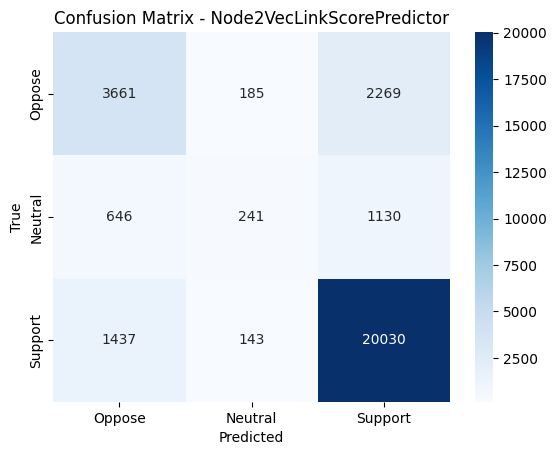

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation of Node2VecLinkScorePredictor (model already in memory)
lp_score_model.eval()
with torch.no_grad():
    X_eval = X_test.to("cuda")
    y_pred = lp_score_model(X_eval).argmax(dim=1).cpu().numpy()
    y_true = (y_test + 1).numpy()  # shift from [-1,0,1] to [0,1,2]

# Classification report
print(classification_report(y_true, y_pred, target_names=["Oppose", "Neutral", "Support"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Oppose", "Neutral", "Support"],
            yticklabels=["Oppose", "Neutral", "Support"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Node2VecLinkScorePredictor")
plt.show()


## Link score prediction with BERT ##

In [18]:
import gzip

# Load dataset
samples = []
with gzip.open("dataset/wiki-RfA.txt.gz", "rt", encoding="utf-8", errors="ignore") as f:
    block = {}
    for line in f:
        line = line.strip()
        if not line:
            if "SRC" in block and "TGT" in block and "VOT" in block:
                # include TXT as well (if present)
                samples.append((
                    block["SRC"],
                    block["TGT"],
                    int(block["VOT"]),
                    block.get("TXT", "")   # textual comment
                ))
            block = {}
        else:
            key, value = line.split(":", 1)
            block[key] = value.strip()

print(f"Total samples: {len(samples)}")


Total samples: 198275


In [19]:
from sklearn.preprocessing import LabelEncoder
import torch

# Encode users as numeric IDs
users = list(set([s[0] for s in samples] + [s[1] for s in samples]))
encoder = LabelEncoder()
user_ids = encoder.fit_transform(users)
user_map = dict(zip(users, user_ids))

# Build X, y and texts lists
X, y, texts = [], [], []
for src, tgt, vot, txt in samples:
    if src in user_map and tgt in user_map:
        X.append([user_map[src], user_map[tgt]])
        y.append(vot)
        texts.append(txt if txt.strip() else "[UNK]")  # use [UNK] for missing comments

X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)


In [20]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to("cuda")

def encode_texts(texts, batch_size=32):
    all_embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
        inputs = {k: v.to("cuda") for k,v in inputs.items()}
        with torch.no_grad():
            outputs = bert_model(**inputs)
        embs = outputs.last_hidden_state[:,0,:].cpu()  # CLS token
        all_embs.append(embs)
    return torch.cat(all_embs, dim=0)


In [21]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Split X, y and raw texts
X_train, X_temp, y_train, y_temp, texts_train_raw, texts_temp_raw = train_test_split(
    X, y, texts, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test, texts_val_raw, texts_test_raw = train_test_split(
    X_temp, y_temp, texts_temp_raw, test_size=0.66, random_state=42
)


In [22]:
# Computes  BERT embedding for train, val and test
texts_train = encode_texts(texts_train_raw)
texts_val   = encode_texts(texts_val_raw)
texts_test  = encode_texts(texts_test_raw)


In [23]:
# Dataset and DataLoader
train_dataset = TensorDataset(X_train, y_train, texts_train)
val_dataset   = TensorDataset(X_val, y_val, texts_val)
train_loader  = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader    = DataLoader(val_dataset, batch_size=256)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HybridLinkScorePredictor(nn.Module):
    def __init__(self, num_users, node_emb_dim=64, text_emb_dim=768, hidden_dim=256):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, node_emb_dim)
        self.fc1 = nn.Linear(node_emb_dim*2 + text_emb_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 3)
        self.unk_text_emb = nn.Parameter(torch.zeros(1, text_emb_dim))

    def forward(self, x, text_emb=None):
        src, tgt = x[:,0], x[:,1]
        src_emb = self.user_emb(src)
        tgt_emb = self.user_emb(tgt)
        if text_emb is None:
            text_emb = self.unk_text_emb.repeat(src_emb.size(0), 1)
        h = torch.cat([src_emb, tgt_emb, text_emb], dim=1)
        h = F.relu(self.fc1(h))
        return self.fc2(h)


In [25]:
import torch.optim as optim

model = HybridLinkScorePredictor(num_users=len(user_map)).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

best_val_loss = float("inf")
patience, patience_counter = 5, 0

for epoch in range(30):
    model.train()
    total_loss = 0
    for xb, yb, tb in train_loader:
        xb, yb, tb = xb.to("cuda"), yb.to("cuda"), tb.to("cuda")
        optimizer.zero_grad()
        out = model(xb, text_emb=tb)
        loss = loss_fn(out, yb + 1)  # shift labels from [-1,0,1] to [0,1,2]
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb, tb in val_loader:
            xb, yb, tb = xb.to("cuda"), yb.to("cuda"), tb.to("cuda")
            out = model(xb, text_emb=tb)
            val_loss += loss_fn(out, yb + 1).item()
    val_loss /= len(val_loader)
    print(f"[BERT LSP] Epoch {epoch}, Train Loss: {total_train_loss:.4f}, Val Loss: {total_val_loss:.4f}")

    # Early stopping (no checkpointing)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


[BERT LSP] Epoch 0, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 1, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 2, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 3, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 4, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 5, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 6, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 7, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 8, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 9, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 10, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 11, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 12, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 13, Train Loss: 206.7405, Val Loss: 63.9661
Early stopping triggered


              precision    recall  f1-score   support

      Oppose       0.48      0.47      0.48      8171
     Neutral       0.16      0.28      0.20      2606
     Support       0.85      0.79      0.82     28482

    accuracy                           0.69     39259
   macro avg       0.49      0.51      0.50     39259
weighted avg       0.72      0.69      0.71     39259



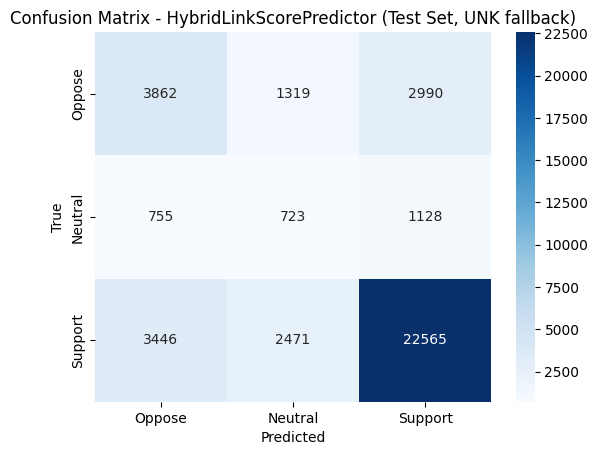

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation of HybridLinkScorePredictor
model.eval()
with torch.no_grad():
    X_eval = X_test.to("cuda")
    y_true = (y_test + 1).numpy()

    y_pred = model(X_eval).argmax(dim=1).cpu().numpy()

# Classification report
print(classification_report(y_true, y_pred, target_names=["Oppose","Neutral","Support"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Oppose","Neutral","Support"],
            yticklabels=["Oppose","Neutral","Support"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - HybridLinkScorePredictor (Test Set, UNK fallback)")
plt.show()


              precision    recall  f1-score   support

      Oppose       0.86      0.92      0.89      8171
     Neutral       0.69      0.70      0.70      2606
     Support       0.98      0.96      0.97     28482

    accuracy                           0.93     39259
   macro avg       0.84      0.86      0.85     39259
weighted avg       0.93      0.93      0.93     39259



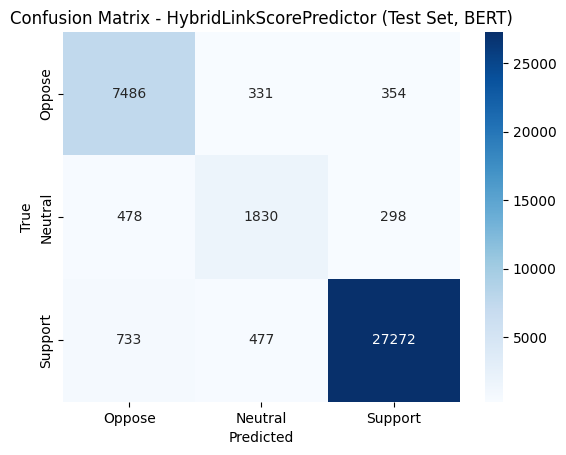

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# With bert test embeddings (this is considering cheating since the model can see test data comments)
model.eval()
with torch.no_grad():
    X_eval = X_test.to("cuda")
    y_true = (y_test + 1).numpy()
    y_pred = model(X_eval, text_emb=texts_test.to("cuda")).argmax(dim=1).cpu().numpy()

# Classification report
print(classification_report(y_true, y_pred, target_names=["Oppose","Neutral","Support"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Oppose","Neutral","Support"],
            yticklabels=["Oppose","Neutral","Support"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - HybridLinkScorePredictor (Test Set, BERT)")
plt.show()
